# Predicting house prices
## a regression example

In [1]:
from keras.datasets import boston_housing


# 집 값 (수치) 예측하기.
# 13가지의 feature (범죄율, 방 개수, 고속도로 접근성, 등)

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

In [3]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [4]:
# 라벨: 집값 (단위: 천 달러)
print( train_targets[0], "thousand $" )

15.2 thousand $


In [5]:
# Normalizing data
# feature의 범위가 제각각이기 때문에 정규화를 해야 학습이 잘 된다.

# train 데이터에 대해 평균, 표준편차를 구해둔다.
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

# 구한 평균, 표준편차를 이용해, train 데이터와 test 데이터 모두 정규분포로 바꾼다.
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

In [6]:
# 네트워크 구성

from keras import models
from keras import layers


# 똑같은 네트워크 구조의 모델을 여러 번 만들어야 한다면, 이렇게 함수로 만들어 이용하는 것이 편하다.

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
              input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])  # MAE
    return model

# metrics로 accuracy가 아닌 MAE (Mean Absolute Error) 를 측정하는데,
# 에러의 절대값의 평균, 즉 예측한 가격과 실제 가격의 평균 차이이다.
# MAE가 0.5 나왔다면, 평균 500$ 오차가 있는 것이다.

In [7]:
# K-fold Validation

# train 데이터를 K등분하여, 번갈아가며 validation 데이터로 이용하며 학습하는 방법.
# 모델의 정확도를 더 잘 측정하는 방법이다.

import numpy as np

k = 4

num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [8]:
for i in range(k):
    print('processing fold #', i)
    
    # k등분한 것 중 i번째의 데이터를 validation 데이터로 이용
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # i번째의 데이터 외의 나머지 (k-1)개를 이어붙여(concatenate) 학습에 이용
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # 네트워크 생성 및 학습
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    
    # validation 데이터를 이용하여 정확도 측정
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    
    # 측정한 값을 기록해둠
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
# k개의 에러값
print( all_scores )
print( np.mean(all_scores) )

[1.932847544698432, 2.416234028221357, 2.5112842663679973, 2.3895901807463997]
2.3124890050085463


In [10]:
# epoch을 100에서 500으로 높여서 다시 학습

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    
    # 이번에는 epoch에 따른 error 그래프를 그려보기 위해 history를 남김
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [11]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

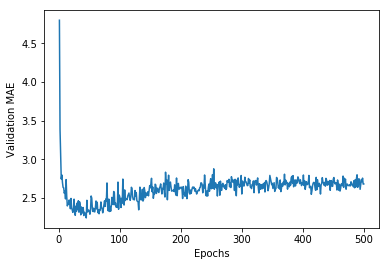

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

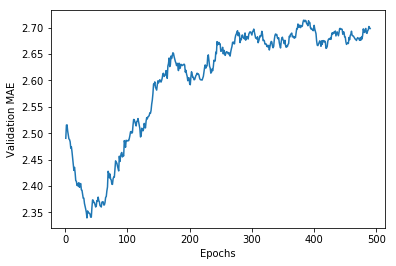

In [13]:
# 위 그래프는 극초반에 뚝 떨어진 후 굉장히 불안정하게 오르내리며 변하는 모습을 보인다.
# 결과의 특성을 더 잘 파악하기 위하여, 값의 변화를 smooth하게 보정하여 다시 그려본다.

# smooth_curve 함수는,
#   new[i] = new[i-1]*0.9 + old[i]*0.1
# 이러한 계산을 해줌으로써 조금 더 매끄러운 곡선을 만들어준다.

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# 극초반의 급격히 떨어지는 구간은 제외하고 [10:] 의 데이터만 이용한다.
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [14]:
# 위 그래프로 보아 epoch을 100 이상 진행할 이유가 없어보이고,
# 특히, 약 epoch=80 부터는 급격하게 error가 올라간다.
# epoch=80으로 학습을 해본다.

model = build_model()
model.fit(train_data, train_targets,
          epochs=120, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 950us/step


In [15]:
print( test_mse_score, test_mae_score )

16.123713923435584 2.581185499827067


##### 끝. <br><br><br>